In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/mlpf/")
from sklearn.cluster import DBSCAN
from torch_scatter import scatter_max, scatter_add, scatter_mean
from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [339]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
from src.evaluation.refactor.preprocess import preprocess_dataframe, renumber_batch_idx
list_all_df_hdb = []
path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_hdbscan_option1.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

path_hgcal = "/eos/home-g/gkrzmanc/2024/results/eval_10_09_testset_300_files_avg_pos/showers_df_evaluation/0_0_None_hdbscan.pt"
sd_hgb1, matched_hgb = open_mlpf_dataframe(path_hgcal, False)


path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_pandora_old_v3.pt"
# path_hgcal = "/eos/home-g/gkrzmanc/2024/results/eval_10_09_testset_300_files_avg_pos/showers_df_evaluation/0_0_None_pandora_oldpandora.pt"
sd_pandora, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

path_hgcal = "/eos/home-g/gkrzmanc/2024/results/eval_10_09_testset_300_files_avg_pos/showers_df_evaluation/0_0_None_pandora.pt"
sd_pandora1, matched_hgbq1 = open_mlpf_dataframe(path_hgcal, False)

# path_hgcal = "/eos/user/m/mgarciam/datasets_mlpf/models_trained_CLD/eval_comp_05/showers_df_evaluation/0_0_None_hdbscan_gt_clusters.pt"
# sd_hgb_gt, matched_hgb = open_mlpf_dataframe(path_hgcal, False)
# sd_hgb, sd_pandora = preprocess_dataframe(sd_hgb, sd_pandora, "")
# sd_hgb_gt, sd_pandora = preprocess_dataframe(sd_hgb_gt, sd_pandora, "")


In [340]:
sd_pandora1 = sd_pandora1[sd_pandora1.reco_showers_E==0]
sd_hgb1 = sd_hgb1[sd_hgb1.reco_showers_E==0]
sd_pandora = sd_pandora[(sd_pandora.reco_showers_E>0)*(sd_pandora.number_batch<995)]

In [ ]:
sd_hgb1

In [78]:
# sd_hgb[(sd_hgb.true_showers_E>5)*np.isnan(sd_hgb.pred_showers_E).values*(sd_hgb.pid.isin(id_group))][0:15]

In [79]:
# id_group = [211, -211, -13, 13, 2212, -2212, 321, -321, 3222, 3112, 3224, -3112, -3224]
# sd_pandora[(sd_pandora.true_showers_E>5)*np.isnan(sd_pandora.pred_showers_E).values*(sd_pandora.pid.isin(id_group))][0:15]

In [322]:
sd_pandora1[np.isnan(sd_pandora1.pred_showers_E).values]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,is_track_in_cluster,true_pos,pid_4_class_true
0,1.613408,0.211434,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.7801401019096375, 0.5952158570289612, -0.8...",2.0
4,1.221496,0.461392,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,0.0,0.0,0.0,"[-0.5734591484069824, 0.45106276869773865, -0....",2.0
15,0.027399,0.040458,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.025309043005108833, 0.002997336210682988, ...",3.0
18,0.009599,0.021542,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.008640195243060589, 0.0018656995380297303,...",3.0
19,0.139229,0.140891,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,0.0,0.0,0.0,"[-0.12822148203849792, 0.048733942210674286, -...",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,11.310449,0.000000,NaN,NaN,NaN,NaN,"[nan, nan, nan]",-211.0,124.0,993.0,0.0,"[-9.718214988708496, 5.5921149253845215, -1.48...",1.0
13,0.041057,0.028925,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,124.0,993.0,0.0,"[-0.038480959832668304, -0.005830435547977686,...",3.0
16,0.002805,0.023374,NaN,NaN,NaN,NaN,"[nan, nan, nan]",22.0,124.0,993.0,0.0,"[-0.002529358258470893, -0.0002487015735823661...",3.0
13,1.408399,0.442436,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2112.0,124.0,994.0,0.0,"[-0.22275714576244354, -0.9767002463340759, -0...",2.0


In [323]:
sd_pandora[np.isnan(sd_pandora.pred_showers_E).values]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,...,number_batch,is_track_in_cluster,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,true_pos,pid_4_class_true
0,1.613408,0.211434,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2112.0,NaN,...,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0]",NaN,NaN,"[-0.7801401019096375, 0.5952158570289612, -0.8...",2.0
16,0.139229,0.140891,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",22.0,NaN,...,0.0,0.0,0.0,0,0.0,"[-53.263404846191406, 20.504247665405273, -9.9...",NaN,NaN,"[-0.12822148203849792, 0.048733942210674286, -...",3.0
6,1.288163,0.265638,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",130.0,NaN,...,1.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0]",NaN,NaN,"[-0.9738070368766785, 0.5051937699317932, -0.4...",2.0
2,0.787568,0.413989,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",130.0,NaN,...,4.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0]",NaN,NaN,"[0.10846993327140808, 0.5113801956176758, 0.31...",2.0
1,2.418021,2.371093,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",22.0,NaN,...,5.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0]",NaN,NaN,"[1.1841171979904175, 1.436920404434204, -1.542...",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,3.135917,2.584471,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",211.0,NaN,...,950.0,0.0,0.0,0,0.0,"[1080.3150634765625, 5.916038990020752, -155.7...",NaN,NaN,"[3.1014323234558105, -0.09302480518817902, -0....",1.0
12,0.142533,0.104628,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",22.0,NaN,...,950.0,0.0,0.0,0,0.0,"[126.91753387451172, 24.29650115966797, -34.29...",NaN,NaN,"[0.045545317232608795, -0.06732632964849472, -...",3.0
5,3.362400,1.961895,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2112.0,NaN,...,953.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0]",NaN,NaN,"[-2.883873224258423, 1.426681399345398, -0.266...",2.0
13,1.408399,0.442436,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2112.0,NaN,...,954.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0]",NaN,NaN,"[-0.22275714576244354, -0.9767002463340759, -0...",2.0


In [235]:
sd_pandora1 = sd_pandora1[sd_pandora1.reco_showers_E>0]
sd_pandora = sd_pandora[(sd_pandora.reco_showers_E>0)]
sd_hgb = sd_hgb[sd_hgb.true_showers_E>0]

# sd_hgb_gt = sd_hgb_gt[sd_hgb_gt.true_showers_E>0]


In [289]:
# # sd_hgb = sd_hgb[~np.isnan(sd_pandora.pred_showers_E).values]
# # sd_hgb_gt = sd_hgb_gt[~np.isnan(sd_pandora.pred_showers_E).values]
# sd_pandora_copy = sd_pandora[~np.isnan(sd_pandora.pred_showers_E).values]
# sd_pandora1 = sd_pandora1[~np.isnan(sd_pandora.pred_showers_E).values]
# sd_pandora_copy = sd_pandora_copy[~np.isnan(sd_pandora1.pred_showers_E).values]
# sd_pandora1 = sd_pandora1[~np.isnan(sd_pandora1.pred_showers_E).values]

In [290]:
# sd_hgb_copy = sd_hgb[~np.isnan(sd_hgb.pred_showers_E).values]
# sd_pandora = sd_pandora[~np.isnan(sd_hgb.pred_showers_E).values]

In [291]:
id_group = [130] #[211, -211, -13, 13, 2212, -2212, 321, -321, 3222, 3112, 3224, -3112, -3224] #[2112, 130, 310, 3122, 3212]
sd_pandora= sd_pandora[sd_pandora.pid.isin(id_group)] #+np.isnan(sd_pandora.pid)
sd_pandora1= sd_pandora1[sd_pandora1.pid.isin(id_group)]
sd_hgb =sd_hgb[sd_hgb.pid.isin(id_group)+np.isnan(sd_hgb.pid)] #+np.isnan(sd_hgb.pid)
# sd_hgb_gt= sd_hgb_gt[sd_hgb_gt.pid.isin(id_group)]

In [85]:
# total = np.max(sd_hgb.number_batch)
# list_e = []
# for i in range(0,int(total)):
#     mask = sd_hgb.number_batch==i
#     list_e.append(np.sum(sd_hgb[mask].calibrated_E)/np.sum(sd_hgb[mask].true_showers_E))

# list_ep = []
# for i in range(0,int(total)):
#     mask = sd_pandora.number_batch==i
#     list_ep.append(np.sum(sd_pandora[mask].pandora_calibrated_pfo)/np.sum(sd_pandora[mask].true_showers_E))
# plt.plot(list_e[0:10], 'bx')
# plt.plot(list_ep[0:10], 'ro')

In [292]:
# sd_hgb_copy.calibrated_E[sd_hgb_copy.is_track_in_cluster.values==0] = sd_pandora.pandora_calibrated_pfo[sd_hgb_copy.is_track_in_cluster.values==0]

In [293]:
# sd_hgb_copy.calibrated_E[sd_hgb_copy.is_track_in_cluster==0]

In [43]:
# sd_hgb_copy.pred_pos_matched[sd_hgb_copy.is_track_in_cluster==0] = sd_pandora.pandora_calibrated_pos[sd_hgb_copy.is_track_in_cluster==0]

/tmp/mgarciam/ipykernel_2444153/1146001850.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sd_hgb_copy.pred_pos_matched[sd_hgb_copy.is_track_in_cluster==0] = sd_pandora.pandora_calibrated_pos[sd_hgb_copy.is_track_in_cluster==0]


In [337]:
from src.utils.inference.event_metrics import get_response_for_event_energy
perfect_pid=True
mass_zero=False
ML_pid=False
matched_all = {"ML": sd_hgb1}
matched_pandora = sd_pandora1
event_res_dic = {} 
for key in matched_all:
        matched_ = matched_all[key]
        event_res_dic[key] = get_response_for_event_energy(
                matched_pandora, matched_, perfect_pid=perfect_pid, mass_zero=mass_zero, ML_pid=ML_pid
            )

/afs/cern.ch/work/m/mgarciam/private/mlpf/src/utils/inference/inference_metrics.py:248: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MPV, std68 = torch.mean(torch.tensor(data_for_hist)).item(), torch.std(torch.tensor(data_for_hist)).item()


ZeroDivisionError: float division by zero

KeyError: 'ML'

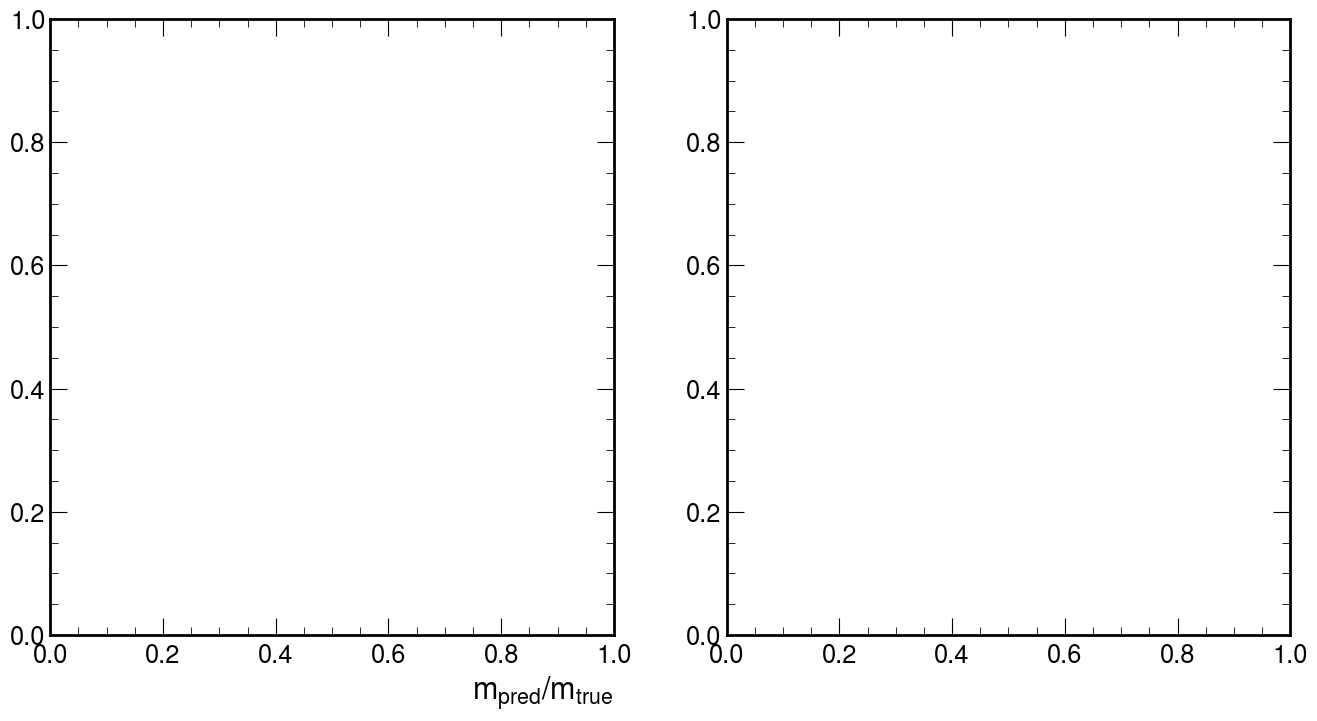

In [338]:

old_font_size = matplotlib.rcParams['font.size']
matplotlib.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 2,figsize=(16, 8))
# set fontsize to 20
ax[0].set_xlabel(r"$m_{pred}/m_{true}$")
bins = np.linspace(0, 2, 200)
ax[0].hist(
    event_res_dic["ML"]["mass_over_true_model"],
    bins=bins,
    histtype="step",
    label="ML $\mu$={}".format(
        round((event_res_dic["ML"]["mean_mass_model"]), 4)
    )+"\n"+"$\sigma/\mu$={}".format(round((event_res_dic["ML"]["var_mass_model"]), 4),
    ),
    color="red",
    density=True,
)
# ax[0].hist(
#     event_res_dic["ML_GTC"]["mass_over_true_model"],
#     bins=bins,
#     histtype="step",
#     label="ML GTC $\mu$={}".format(
#         round((event_res_dic["ML_GTC"]["mean_mass_model"]), 4)
#     )+"\n"+"$\sigma/\mu$={}".format(round((event_res_dic["ML_GTC"]["var_mass_model"]), 4),
#     ),
#     color="green",
#     density=True,
# )


ax[0].hist(
    event_res_dic["ML"]["mass_over_true_pandora"],
    bins=bins,
    histtype="step",
    label="Pandora $\mu$={}".format(
        round((event_res_dic["ML"]["mean_mass_pandora"]), 4)
    )+"\n"+"$\sigma/\mu$={}".format(round((event_res_dic["ML"]["var_mass_pandora"]), 4),
    ),
    color="blue",
    density=True,
)
ax[0].grid()
ax[0].legend(loc='upper left')
#ax.set_xlim([0, 10])
mean_e_over_true_pandora, sigma_e_over_true_pandora = round(event_res_dic["ML"]["mean_energy_over_true_pandora"], 4), round(
    event_res_dic["ML"]["var_energy_over_true_pandora"], 4)
mean_e_over_true, sigma_e_over_true = round(event_res_dic["ML"]["mean_energy_over_true"], 4), round(
    event_res_dic["ML"]["var_energy_over_true"], 4)
# mean_e_over_true_gtc, sigma_e_over_true_gtc = round(event_res_dic["ML_GTC"]["mean_energy_over_true"], 4), round(
#     event_res_dic["ML_GTC"]["var_energy_over_true"], 4)
ax[1].hist(event_res_dic["ML"]["energy_over_true"], bins=bins, histtype="step",
            # label=r"ML $\mu$={} $\sigma / \mu$={}".format(mean_e_over_true, sigma_e_over_true),
            color="red",
            label="ML $\mu$={}".format(
                mean_e_over_true
            )+"\n"+"$\sigma/\mu$={}".format(sigma_e_over_true
            ),
            density=True)
# ax[1].hist(event_res_dic["ML_GTC"]["energy_over_true"], bins=bins, histtype="step",
#             # label=r"ML $\mu$={} $\sigma / \mu$={}".format(mean_e_over_true, sigma_e_over_true),
#             color="green",
#             label="ML GTC $\mu$={}".format(
#                 mean_e_over_true_gtc
#             )+"\n"+"$\sigma/\mu$={}".format(sigma_e_over_true_gtc
#             ),
#             density=True)
ax[1].hist(event_res_dic["ML"]["energy_over_true_pandora"], bins=bins, histtype="step",
                    # label=r"Pandora $\mu$={} $\sigma / \mu$={}".format(mean_e_over_true_pandora,
                    #                                                     sigma_e_over_true_pandora),
                    label="Pandora  $\mu$={}".format(
                        mean_e_over_true_pandora
                    )+"\n"+"$\sigma/\mu$={}".format(sigma_e_over_true_pandora
                    ),
                    color="blue",
                    density=True)

ax[1].grid(1)
ax[1].set_xlabel(r"$E_{vis,pred} / E_{vis,true}$")
ax[1].legend(loc='upper left')

fig.tight_layout()

import os
# fig.savefig(os.path.join(PATH_store, "mass_resolution.pdf"), bbox_inches="tight")
# matplotlib.rcParams.update({'font.size': old_font_size})


In [200]:
# sd_pandora.true_showers_E.values[0:50] == sd_pandora1.true_showers_E.values[0:50]
sd_pandora[18:30]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pandora_ref_pt,pid,pandora_pid,...,number_batch,is_track_in_cluster,is_track_correct,is_track_in_MC,distance_to_cluster_MC,vertex,ECAL_hits,HCAL_hits,true_pos,pid_4_class_true
15,2.339313,1.844770,1.823986,0.892095,2.971115,2.971115,"[0.8274168372154236, -2.7751612663269043, 0.66...","[664.5404052734375, -2383.091796875, 523.61090...",2212.0,0.0,...,34.0,0.0,0.0,0,0.000000,"[232.62521362304688, -1235.6368408203125, 317....",41.0,15.0,"[1.1268714666366577, -1.7750869989395142, 0.41...",1.0
22,1.492993,0.134231,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2212.0,NaN,...,34.0,0.0,0.0,0,0.000000,"[263.79833984375, -1556.11572265625, 364.12893...",NaN,NaN,"[0.649229884147644, -0.7859825491905212, 0.556...",1.0
11,1.368946,0.156234,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2212.0,NaN,...,66.0,0.0,0.0,1,0.017826,"[-595.5049438476562, 306.36016845703125, -682....",NaN,NaN,"[-0.24430330097675323, 0.36559736728668213, -0...",1.0
7,2.525560,1.161050,1.006772,1.006772,1.122457,1.122457,"[0.1649218648672104, 1.104817509651184, 0.1099...","[313.0370788574219, 2304.328369140625, 176.797...",2212.0,0.0,...,70.0,0.0,0.0,0,0.000000,"[178.79095458984375, 987.8990478515625, 105.89...",47.0,0.0,"[-0.06889361143112183, 2.3340306282043457, 0.2...",1.0
11,1.832926,0.609646,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2212.0,NaN,...,70.0,0.0,0.0,0,0.000000,"[-330.20208740234375, 1984.9228515625, 1877.66...",NaN,NaN,"[-0.6563665270805359, 1.2443211078643799, 0.70...",1.0
15,1.864562,1.707420,1.344387,1.344386,1.655276,1.655276,"[-0.2928895354270935, -0.7612512707710266, -1....","[-466.0312194824219, -1375.6007080078125, -249...",2212.0,0.0,...,87.0,0.0,0.0,0,0.000000,"[-200.87152099609375, -352.1282958984375, -410...",45.0,2.0,"[0.06801412254571915, -0.70466548204422, -1.44...",1.0
19,1.290205,0.716406,0.716406,0.716406,0.798726,0.798726,"[-0.4182237386703491, 0.34531939029693604, -0....","[-1620.9434814453125, 1419.39501953125, -2372....",2212.0,0.0,...,87.0,0.0,0.0,0,0.000000,"[-1569.7589111328125, 403.0480041503906, -1401...",18.0,0.0,"[-0.33893242478370667, 0.5608453154563904, -0....",1.0
8,2.161486,0.969605,0.865830,0.858346,0.881216,0.881216,"[-0.8530811667442322, -0.042175617069005966, -...","[-2251.515869140625, -110.25139617919922, -572...",2212.0,0.0,...,93.0,0.0,0.0,0,0.000000,"[-637.8331909179688, -204.55325317382812, -23....",31.0,0.0,"[-1.8140795230865479, -0.3680645823478699, -0....",1.0
14,1.588158,0.631179,0.629275,0.629275,0.701584,0.701584,"[0.6134159564971924, -0.05668484419584274, 0.3...","[2187.56103515625, -219.2676239013672, 1193.10...",2212.0,0.0,...,95.0,0.0,0.0,1,0.060845,"[58.388336181640625, 95.66999816894531, 70.036...",20.0,0.0,"[1.03544020652771, 0.4946969151496887, 0.57011...",1.0
16,1.405872,0.184774,NaN,NaN,NaN,NaN,"[nan, nan, nan]","[nan, nan, nan]",2212.0,NaN,...,97.0,0.0,0.0,0,0.000000,"[-1523.091064453125, -384.6061096191406, 164.0...",NaN,NaN,"[-0.9630069732666016, 0.2579340934753418, 0.31...",1.0


In [199]:
sd_pandora1[18:30]

,true_showers_E,reco_showers_E,pred_showers_E,e_pred_and_truth,pandora_calibrated_E,pandora_calibrated_pfo,pandora_calibrated_pos,pid,step,number_batch,is_track_in_cluster,true_pos,pid_4_class_true
16,2.339313,1.844770,1.823986,0.892095,2.971115,2.971115,"[0.8274168372154236, -2.7751612663269043, 0.66...",2212.0,4.0,34.0,0.0,"[1.1268714666366577, -1.7750869989395142, 0.41...",1.0
20,1.108413,0.173875,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,4.0,34.0,0.0,"[0.22176593542099, -0.5244866609573364, -0.154...",1.0
24,1.492993,0.134231,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,4.0,34.0,0.0,"[0.649229884147644, -0.7859825491905212, 0.556...",1.0
17,1.183334,0.113069,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,4.0,38.0,0.0,"[0.15600629150867462, 0.4982856512069702, -0.4...",1.0
13,1.020270,0.119665,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,5.0,44.0,0.0,"[-0.3099389374256134, -0.2495194971561432, 0.0...",1.0
13,1.076533,0.090221,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,6.0,53.0,0.0,"[-0.1386798769235611, -0.3240469992160797, -0....",1.0
19,1.041481,0.071508,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,7.0,62.0,0.0,"[0.34083113074302673, 0.26214727759361267, 0.1...",1.0
14,1.368946,0.156234,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,8.0,66.0,0.0,"[-0.24430330097675323, 0.36559736728668213, -0...",1.0
9,2.525560,1.161050,1.006771,1.006772,1.122457,1.122457,"[0.1649218648672104, 1.104817509651184, 0.1099...",2212.0,8.0,70.0,0.0,"[-0.06889361143112183, 2.3340306282043457, 0.2...",1.0
13,1.832926,0.609646,NaN,NaN,NaN,NaN,"[nan, nan, nan]",2212.0,8.0,70.0,0.0,"[-0.6563665270805359, 1.2443211078643799, 0.70...",1.0


In [127]:
len(sd_pandora1), len(sd_pandora)

(3193, 2898)